# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
# Load pickled data
training_file   = './data/train.p'
validation_file = './data/valid.p'
testing_file    = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test  = test['features'],  test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
image_shape = X_train[0].shape # Shape of a traffic sign image?

n_train = len(X_train)  # Number of training examples
n_valid = len(X_valid)  # Number of validation examples
n_test  = len(X_test)   # Number of testing examples

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print('Image data shape = {}'.format(image_shape))
print('')
print('Number of training examples   = {}'.format(n_train))
print('Number of validation examples = {}'.format(n_valid))
print('Number of testing examples    = {}'.format(n_test))
print('')
print('Number of classes = {}'.format(n_classes))

Image data shape = (32, 32, 3)

Number of training examples   = 34799
Number of validation examples = 4410
Number of testing examples    = 12630

Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Signs:
                                                  SignName
ClassId                                                   
0                                     Speed limit (20km/h)
1                                     Speed limit (30km/h)
2                                     Speed limit (50km/h)
3                                     Speed limit (60km/h)
4                                     Speed limit (70km/h)
5                                     Speed limit (80km/h)
6                              End of speed limit (80km/h)
7                                    Speed limit (100km/h)
8                                    Speed limit (120km/h)
9                                               No passing
10            No passing for vehicles over 3.5 metric tons
11                   Right-of-way at the next intersection
12                                           Priority road
13                                                   Yield
14                                               

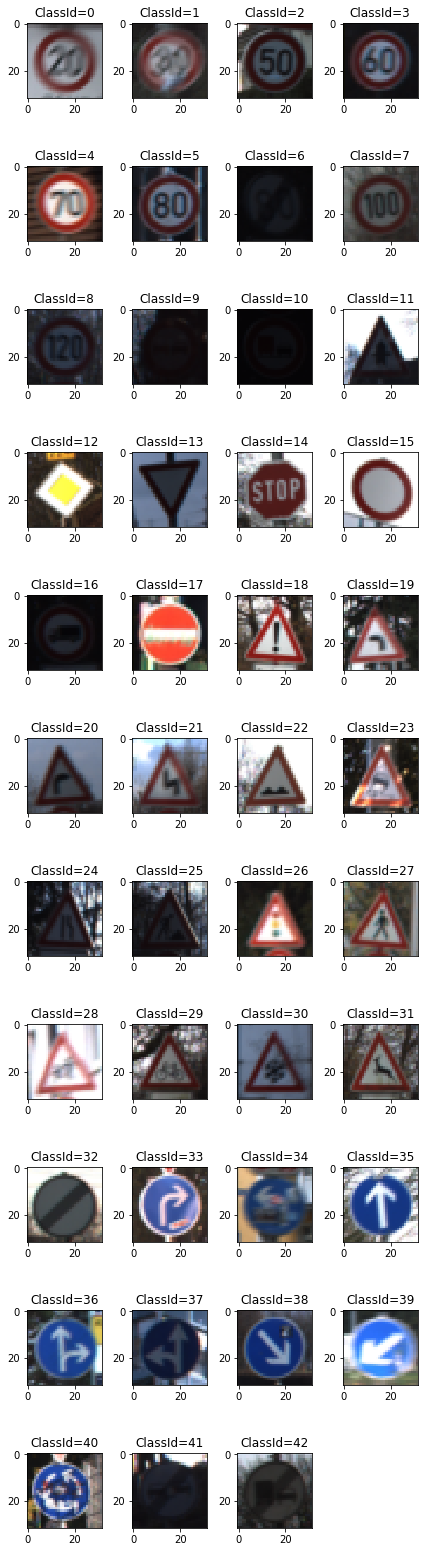

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Load the sign name lookup table.
sign_names_file = './data/signnames.csv'
sign_names = pd.read_csv(sign_names_file, index_col=['ClassId'])
print('Signs:\n{}'.format(sign_names.head(50)))

# Display a sample of each sign type.
label_dict = {k: v for v, k in enumerate(y_train)}

fig = plt.figure(figsize=(6, 22))
columns = 4
rows = int((n_classes / columns) + 1)
for k in label_dict:
    index = label_dict[k]
    image = X_train[index].squeeze()
    ax = fig.add_subplot(rows, columns, k+1)
    ax.set_title('ClassId={}'.format(k))
    plt.imshow(image, cmap='gray')
fig.tight_layout()
plt.show()

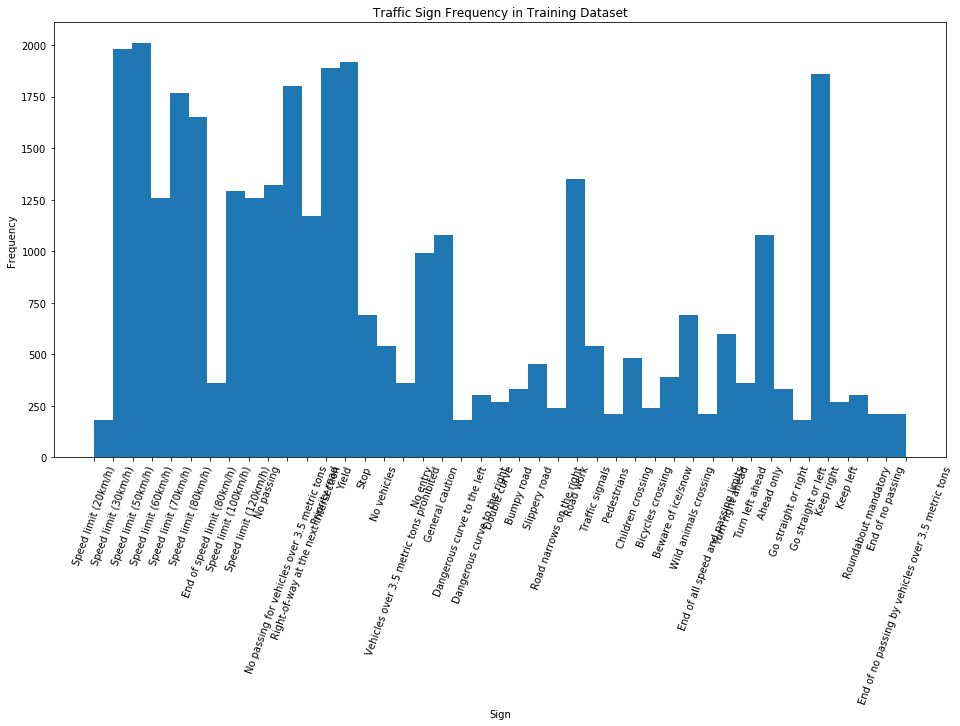

In [5]:
# Convert the training label data to a DataFrame to make it easier to
# display a histogram using sign names rather than ids.
signs = pd.DataFrame(y_train, columns=['ClassId'])
signs = signs.merge(sign_names, how='inner', on='ClassId')

# Display a histogram of sign names.
fig, ax = plt.subplots()
n, bins, patches = ax.hist(signs['ClassId'].tolist(), bins=n_classes)
plt.setp(ax.xaxis.get_ticklabels(), rotation=70)
ax.set_xticks(sign_names.index)
ax.set_xticklabels(sign_names['SignName'])
ax.set_xlabel('Sign')
ax.set_ylabel('Frequency')
ax.set_title('Traffic Sign Frequency in Training Dataset')
fig.set_size_inches(16, 8)

# Save the histogram for the writeup.
plt.savefig('./writeup_images/histogram.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Hyperparameters

In [10]:
# Data prep parameters
MAX_IMAGE_SCALE         = 2.0   # Max. image scale factor.
MAX_IMAGE_TRANSLATION   = 2     # Max. +/- image x/y translation in pixels.
MAX_IMAGE_ROTATION      = 10.0  # Max. +/- image rotation in degrees.
MAX_IMAGE_INTENSITY_MOD = 50.0  # Max +/- image intensity modification.

# Model parameters: arguments used for tf.truncated_normal in LeNet(),
# randomly defines variables for the weights and biases for each layer
MU    = 0
SIGMA = 0.1

# Training parameters
DROPOUT_KEEP_PROB = 0.5
LEARNING_RATE     = 0.001
EPOCHS            = 25
BATCH_SIZE        = 256

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def grayscale_and_normalize(X):
    """
    Prepare image data for further processing. Steps:
        1. Convert to grayscale.
        2. Normalize the image data so that it has mean zero and
        equal variance.
    Assume that the images have dimensions (32, 32, 3) on input.
    After processing the images will have dimensions (32, 32, 1).

    Args:
        X: An array of images.

    Returns:
        A grayscale, normalized array of images.
    """

    # Convert from RGB to grayscale and normalize.
#    X = [normalize(grayscale(img)) for img in X]
#    X = [normalize_min_max(grayscale(img)) for img in X]
    # Using the either of the above steps to convert to grayscale and
    # normalize does not work well and causes the model accuracy to be
    # extremely low. I don't know why but the following two simple lines
    # of code yield much better results.
    X = np.sum(X / 3, axis=3, keepdims=True)
    X = (X - 128) / 128

    return X

def grayscale(image):
    """
    Convert an RGB image to grayscale.

    Args:
        image: Image to be converted.

    Returns:
        A grayscale image.
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img= img[:, :, np.newaxis]
    return img

def normalize(image):
    """
    Normalize an image array.

    Assume the image is stored as an array or matrix of uint8. Since the max
    value of uint8 is 255 we use 128 (255 / 2) as the constant in the
    formula below.

    Args:
        image: input image

    Returns:
        Normalized image
    """
    return image - 128 / 128

def normalize_min_max(image):
    """
    Normalize the image with Min-Max scaling to a range of [0.1, 0.9]

    Args:
        image: The image to be normalized

    Returns:
        Normalized image data
    """
    # Normalize image data to the range [a, b]
    a = 0.1
    b = 0.9
    d = b - a  # delta

    # Assume image data is in grayscale, with the current values in
    # the range [0, 255] (uint8).
    x_min = 0
    x_max = 255
    x_del = x_max - x_min  # delta

    # x' = a + ((x - x_min) * (b - a)) / (x_max - x_min)
    normalized_image = [a + ((x.astype(float) - x_min) * d) / x_del for x in image]

    return normalized_image

def add_modified_images(X, y, n_classes, min_sample_size):
    """
    Given an array of images, ensure that each image class has a minimum
    number of instance.

    In cases where there are less than minimum number of instances of a
    particular image class, we add new images to make up the difference.

    The new images are modified copies of the original images. The
    modification consists of:
        1. Random intensity modification.
        2. Random rotation.
        3. Random translation.
        4. Random scaling.

    Args:
        X: An array of images.
        y: An array of labels.
        n_classes: Number of label classes.

    Returns:
        A modified array of images, labels.
    """
    for classId in range(n_classes):
        class_indices = np.where(y == classId)
        n_samples = len(class_indices[0])
        if n_samples < min_sample_size:
            X_new = []
            for i in range(min_sample_size - n_samples):
                new_img = X[class_indices[0][i % n_samples]]
                new_img = random_translate(random_rotate(random_scale(random_intensity(new_img))))
                X_new.append(new_img)
            X = np.append(X, X_new, axis=0)
            y_new = []
            [y_new.append(classId) for i in range(min_sample_size - n_samples)]
            y = np.append(y, y_new, axis=0)

    return X, y

def random_translate(image):
    """
    Randomly translate an image.

    Args:
        image: The image to be translated.

    Returns:
        The translated image.
    """
    translation = random.randint(-MAX_IMAGE_TRANSLATION, MAX_IMAGE_TRANSLATION)
    rows, cols, _ = image.shape
    M = np.float32([[1, 0, translation],   # x translation
                    [0, 1, translation]])  # y translation
    img = cv2.warpAffine(image, M, (cols, rows))

    img = img[:, :, np.newaxis]

    return img

def random_rotate(image):
    """
    Randomly rotate an image.

    Args:
        image: The image to be rotated.

    Returns:
        The rotated image.
    """
    angle = random.uniform(-MAX_IMAGE_ROTATION, MAX_IMAGE_ROTATION)
#    return rotate_bound(image, angle)
    return rotate(image, angle)

def rotate(image, angle):
    """
    Rotate an image using OpenCV such that the entire image is preserved.

    Args:
        image: The image to be rotated.
        angle: Rotation angle.

    Returns:
        The rotated image.

    Reference:
        OpenCV documentation
        https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html
    """
    rows, cols, _ = image.shape
    # cols-1 and rows-1 are the coordinate limits.
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
    img = cv2.warpAffine(image, M, (cols, rows))

    img = img[:, :, np.newaxis]

    return img

def rotate_bound(image, angle):
    """
    Rotate an image using OpenCV such that the entire image is preserved.

    Warning!
    This method may change the image size.

    Args:
        image: The image to be rotated.
        angle: Rotation angle.

    Returns:
        The rotated image.

    Reference:
        Rotate images (correctly) with OpenCV and Python
        by Adrian Rosebrock on January 2, 2017 in OpenCV 3, Tutorials
        https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    """
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    img = cv2.warpAffine(image, M, (nW, nH))

    img = img[:, :, np.newaxis]

    return img

def random_scale(image):
    """
    Randomly scale an image.

    Args:
        image: The image to be scaled.

    Returns:
        The scaled image.
    """

    rows, cols, _ = image.shape
    sf = random.randint(-MAX_IMAGE_SCALE, MAX_IMAGE_SCALE)  # scale factor

    # src:
    pts1 = np.float32([[sf,        sf], [rows - sf,        sf],
                       [sf, cols - sf], [rows - sf, cols - sf]])
    # dst: four corners of the image
    pts2 = np.float32([[0,    0], [rows,    0],
                       [0, cols], [rows, cols]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(image, M, (rows, cols))

    img= img[:, :, np.newaxis]

    return img

def random_intensity(image):
    """
    Randomly modify the intensity of an image.

    Args:
        image: The image to be modified.

    Returns:
        The modified image.
    """
    intensity_delta = np.uint8(random.randint(-MAX_IMAGE_INTENSITY_MOD,
                                              MAX_IMAGE_INTENSITY_MOD))
    if intensity_delta > 0:
        np.where((255 - image) < intensity_delta, 255, image + intensity_delta)
    else:
        np.where(image < intensity_delta, 0, image + intensity_delta)
    return image

In [12]:
# Image augmentation samples.
sample = X_train[random.randint(0, n_train)]

sample_grayscale  = grayscale(sample)
sample_normalized = normalize(sample_grayscale)
sample_intensity  = random_intensity(sample_normalized)
sample_scaled     = random_scale(sample_normalized)
sample_rotated    = random_rotate(sample_normalized)
sample_translated = random_translate(sample_normalized)

# Save images for inclusion in writeup.
mpimg.imsave(fname='./writeup_images/sample.png',            arr=sample[:,:,0],            format='png')
mpimg.imsave(fname='./writeup_images/sample_grayscale.png',  arr=sample_grayscale[:,:,0],  format='png')
mpimg.imsave(fname='./writeup_images/sample_normalized.png', arr=sample_normalized[:,:,0], format='png')
mpimg.imsave(fname='./writeup_images/sample_intensity.png',  arr=sample_intensity[:,:,0],  format='png')
mpimg.imsave(fname='./writeup_images/sample_scaled.png',     arr=sample_scaled[:,:,0],     format='png')
mpimg.imsave(fname='./writeup_images/sample_rotated.png',    arr=sample_rotated[:,:,0],    format='png')
mpimg.imsave(fname='./writeup_images/sample_translated.png', arr=sample_translated[:,:,0], format='png')

Text(0.5, 1.0, 'Grayscale Image')

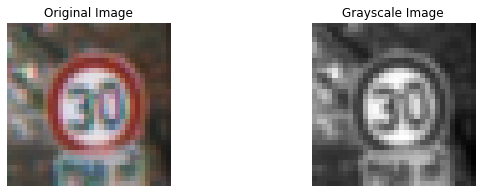

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(sample.squeeze(), cmap='gray')
axs[0].set_title('Original Image')

axs[1].axis('off')
axs[1].imshow(sample_grayscale.squeeze(), cmap='gray')
axs[1].set_title('Grayscale Image')

Text(0.5, 1.0, 'Normalized Grayscale Image')

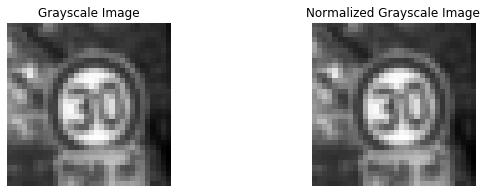

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(sample_grayscale.squeeze(), cmap='gray')
axs[0].set_title('Grayscale Image')

axs[1].axis('off')
axs[1].imshow(sample_normalized.squeeze(), cmap='gray')
axs[1].set_title('Normalized Grayscale Image')

Text(0.5, 1.0, 'Random Intensity Modification')

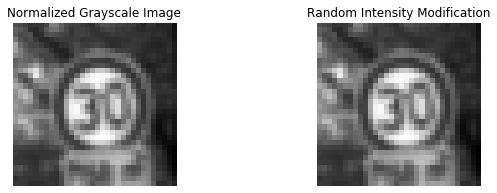

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(sample_normalized.squeeze(), cmap='gray')
axs[0].set_title('Normalized Grayscale Image')

axs[1].axis('off')
axs[1].imshow(sample_intensity.squeeze(), cmap='gray')
axs[1].set_title('Random Intensity Modification')

Text(0.5, 1.0, 'Random Scaling')

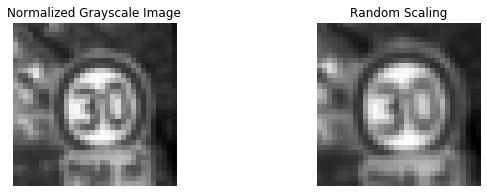

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(sample_normalized.squeeze(), cmap='gray')
axs[0].set_title('Normalized Grayscale Image')

axs[1].axis('off')
axs[1].imshow(sample_scaled.squeeze(), cmap='gray')
axs[1].set_title('Random Scaling')

Text(0.5, 1.0, 'Random Rotation')

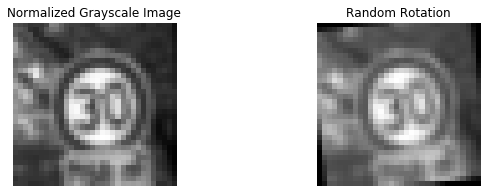

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(sample_normalized.squeeze(), cmap='gray')
axs[0].set_title('Normalized Grayscale Image')

axs[1].axis('off')
axs[1].imshow(sample_rotated.squeeze(), cmap='gray')
axs[1].set_title('Random Rotation')

Text(0.5, 1.0, 'Random Translation')

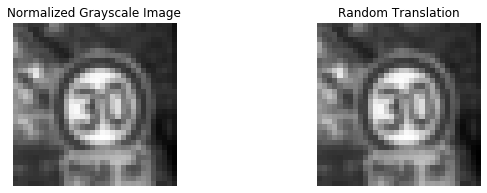

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(sample_normalized.squeeze(), cmap='gray')
axs[0].set_title('Normalized Grayscale Image')

axs[1].axis('off')
axs[1].imshow(sample_translated.squeeze(), cmap='gray')
axs[1].set_title('Random Translation')

Text(0.5, 1.0, 'New Image')

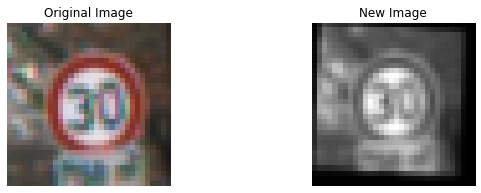

In [19]:
sample_new = random_translate(random_rotate(random_scale(random_intensity(sample_normalized))))

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(sample.squeeze(), cmap='gray')
axs[0].set_title('Original Image')

axs[1].axis('off')
axs[1].imshow(sample_new.squeeze(), cmap='gray')
axs[1].set_title('New Image')

**Note:** The "New Image" shown in the above cell will not match the intermediate images above since it was created by applying the four random image augmentation steps (intensity, scaling, rotation, translation) to the normalized image. Since the operations are random the images will not match.

In [20]:
# Preprocess the data
print('Data preparation...')

print('Grayscale+normalization for training data ...')
X_train = grayscale_and_normalize(X_train)
print('Grayscale+normalization for validation data ...')
X_valid = grayscale_and_normalize(X_valid)
print('Grayscale+normalization for test data ...')
X_test  = grayscale_and_normalize(X_test)

print('Data augmentation for training data ...')
X_train, y_train = add_modified_images(X_train, y_train, n_classes, 700)
print('Data augmentation for validation data ...')
X_valid, y_valid = add_modified_images(X_valid, y_valid, n_classes,  50)
# Do *not* add modified images to the test dataset.

# Shuffle
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test,  y_test  = shuffle(X_test,  y_test)

Data preparation...
Grayscale+normalization for training data ...
Grayscale+normalization for validation data ...
Grayscale+normalization for test data ...
Data augmentation for training data ...
Data augmentation for validation data ...


### Model Architecture

In [21]:
def conv2d(x, W, b, strides=1):
    """
    Add a convolution layer using ReLu as the activation function.

    Args:
        x: input data
        W: weights
        b: bias
        strides: stride size (assume square stride)

    Returns:
        A TensorFlow convolution layer.
    """
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    """
    Add a max pooling layer.

    Args:
        x: input data
        k: filter size

    Returns:
        A TensorFlow max pooling layer.
    """
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='VALID')

def LeNet(x, n_classes, keep_prob):
    """
    Implement a slightly modified LeNet-5 model.
    The modification is to include a dropout op for each of the two
    fully connected layers.

    Args:
        x: input data
        n_classes: number of output classes
        keep_prob: TensorFlow placeholder for dropout keep probability

    Returns:
        A TensorFlow LeNet-5 model.
    """

    # Store layer weights & biass
    weights = {
        # convolution weights: [filter height, filter width, input depth, output depth]
        'wc1': tf.Variable(tf.random_normal([5, 5, 1, 6],    mean=MU, stddev=SIGMA)),
        'wc2': tf.Variable(tf.random_normal([5, 5, 6, 16],   mean=MU, stddev=SIGMA)),
        # fully connected weights: [input length, output length]
        'wd1': tf.Variable(tf.random_normal([400, 120],      mean=MU, stddev=SIGMA)),
        'wd2': tf.Variable(tf.random_normal([120, 84],       mean=MU, stddev=SIGMA)),
        'out': tf.Variable(tf.random_normal([84, n_classes], mean=MU, stddev=SIGMA))}

    biases = {
        # convolution bias: [output depth]
        'bc1': tf.Variable(tf.random_normal([6],         mean=MU, stddev=SIGMA)),
        'bc2': tf.Variable(tf.random_normal([16],        mean=MU, stddev=SIGMA)),
        # fully connected bias: [output length]
        'bd1': tf.Variable(tf.random_normal([120],       mean=MU, stddev=SIGMA)),
        'bd2': tf.Variable(tf.random_normal([84],        mean=MU, stddev=SIGMA)),
        'out': tf.Variable(tf.random_normal([n_classes], mean=MU, stddev=SIGMA))}

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Activation.
    layer1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1 = maxpool2d(layer1, k=2)  # k=2 -> cut input size in half

    # Layer 2: Convolutional. Output = 10x10x16.
    # Activation.
    layer2 = conv2d(layer1, weights['wc2'], biases['bc2'])
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2 = maxpool2d(layer2, k=2)  # k=2 -> cut input size in half

    # Flatten. Input = 5x5x16. Output = 400.
    layer2 = flatten(layer2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Activation.
    layer3 = tf.add(tf.matmul(layer2, weights['wd1']), biases['bd1'])
    layer3 = tf.nn.relu(layer3)
    layer3 = tf.nn.dropout(layer3, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # Activation.
    layer4 = tf.add(tf.matmul(layer3, weights['wd2']), biases['bd2'])
    layer4 = tf.nn.relu(layer4)
    layer4 = tf.nn.dropout(layer4, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(layer4, weights['out']), biases['out'])

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
def evaluate(X_data, y_data, x, y, keep_prob, accuracy_operation):
    """
    Evalutation function used for training.

    Args:
        X_data: input data
        y_data: labels
        x, y: TensorFlow placeholders for accuracy data
        keep_prob: TensorFlow placeholder for dropout keep probability
        accuracy_operation: TensorFlow accuracy operation

    Returns:
        Average accuracy for all batches.
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation,
                            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [24]:
# Train the model on the training data.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)  # Keep probability for dropout.

logits             = LeNet(x, n_classes, keep_prob)
cross_entropy      = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation     = tf.reduce_mean(cross_entropy)
optimizer          = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print('Training...')
    print('')
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation,
                     feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT_KEEP_PROB})

        valid_accuracy = evaluate(X_valid, y_valid, x, y, keep_prob, accuracy_operation)
        print('EPOCH {} ...'.format(i+1))
        print('Validation Accuracy = {:.3f}'.format(valid_accuracy))
        print('')

    saver.save(sess, './lenet')
    print('Model saved')

Training...

EPOCH 1 ...
Validation Accuracy = 0.522

EPOCH 2 ...
Validation Accuracy = 0.707

EPOCH 3 ...
Validation Accuracy = 0.828

EPOCH 4 ...
Validation Accuracy = 0.854

EPOCH 5 ...
Validation Accuracy = 0.876

EPOCH 6 ...
Validation Accuracy = 0.894

EPOCH 7 ...
Validation Accuracy = 0.903

EPOCH 8 ...
Validation Accuracy = 0.910

EPOCH 9 ...
Validation Accuracy = 0.910

EPOCH 10 ...
Validation Accuracy = 0.913

EPOCH 11 ...
Validation Accuracy = 0.918

EPOCH 12 ...
Validation Accuracy = 0.925

EPOCH 13 ...
Validation Accuracy = 0.922

EPOCH 14 ...
Validation Accuracy = 0.931

EPOCH 15 ...
Validation Accuracy = 0.931

EPOCH 16 ...
Validation Accuracy = 0.928

EPOCH 17 ...
Validation Accuracy = 0.930

EPOCH 18 ...
Validation Accuracy = 0.937

EPOCH 19 ...
Validation Accuracy = 0.934

EPOCH 20 ...
Validation Accuracy = 0.936

EPOCH 21 ...
Validation Accuracy = 0.941

EPOCH 22 ...
Validation Accuracy = 0.931

EPOCH 23 ...
Validation Accuracy = 0.935

EPOCH 24 ...
Validation Accura

In [25]:
# Calculate and display accuracy for the model on the test data.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, x, y, keep_prob, accuracy_operation)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.929


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [26]:
# Load additional test images and labels.
X_test_2 = []
y_test_2 = []
image_labels_file = './test_images/image_labels.csv'
image_labels = pd.read_csv(image_labels_file, index_col=['ImageId'])
for index, row in image_labels.iterrows():
    image_file = './test_images/image' + str(index).zfill(2) + '.jpg'
    image = mpimg.imread(image_file)
    image = cv2.resize(image, (32, 32))  # Scale to 32x32x3
    X_test_2.append(image)
    y_test_2.append(row['ClassId'])
X_test_2 = np.array(X_test_2)
y_test_2 = np.array(y_test_2)

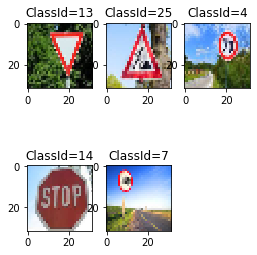

In [27]:
# Display additional test images.
label_2_dict = {v: k for v, k in enumerate(y_test_2)}

fig = plt.figure(figsize=(4, 5))
columns = 3
rows = 2
for index, image in enumerate(X_test_2):
    class_id = label_2_dict[index]
    image = image.squeeze()
    ax = fig.add_subplot(rows, columns, index+1)
    ax.set_title('ClassId={}'.format(class_id))
    plt.imshow(image, cmap='gray')
fig.subplots_adjust(hspace=.1, wspace=.2)
plt.show()

### Predict the Sign Type for Each Image

In [28]:
# Normalize the new test data.
X_test_2_normalized = grayscale_and_normalize(X_test_2)

In [29]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for offset in range(len(X_test_2_normalized)):
        end = offset + 1
        batch_x, batch_y = X_test_2_normalized[offset:end], y_test_2[offset:end]
        accuracy = sess.run(accuracy_operation,
                            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        print("Test Accuracy (image{}) = {:.3f}".format(str(offset).zfill(2), accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy (image00) = 1.000
Test Accuracy (image01) = 1.000
Test Accuracy (image02) = 0.000
Test Accuracy (image03) = 1.000
Test Accuracy (image04) = 0.000


### Analyze Performance

In [30]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_2_accuracy = evaluate(X_test_2_normalized, y_test_2, x, y, keep_prob, accuracy_operation)
    print("Test Accuracy (2) = {:.3f}".format(test_2_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy (2) = 0.600


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from .\lenet


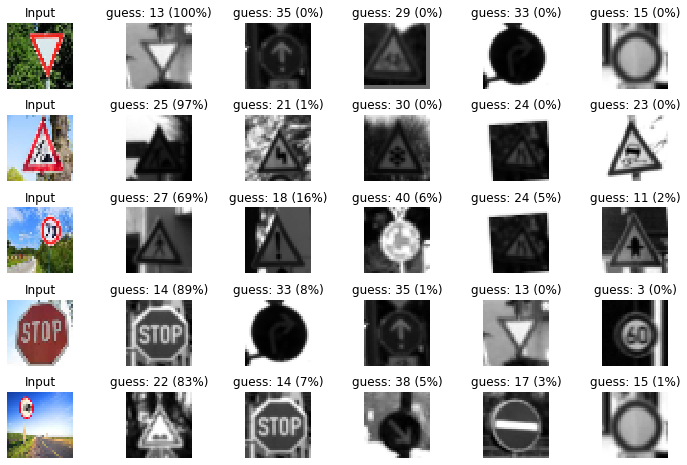

In [31]:
# Top five softmax probabilities for additional test data.
softmax_logits = tf.nn.softmax(logits)
k = 5
top_k_op = tf.nn.top_k(softmax_logits, k=k)

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(top_k_op,
                     feed_dict={x: X_test_2_normalized, keep_prob: 1.0})

    fig, ax = plt.subplots(len(X_test_2), 1+k, figsize=(12, 8))
    fig.subplots_adjust(hspace=.4, wspace=.6)
    
    # top_k[0] == softmax probabilities
    # top_k[1] == index of the best guess
    # top_k[:, i, k] == probability/best guess for image i, rank k
    for i, image in enumerate(X_test_2):
        ax[i][0].axis('off')
        ax[i][0].imshow(image)
        ax[i][0].set_title('Input')
        for k in range(5):
            # Use X_valid, y_valid assuming that this dataset contains
            # at least one instance of each traffic sign class.
            prob  = 100*top_k[0][i][k]
            guess = top_k[1][i][k]
            index = np.argwhere(y_valid == guess)[0]
            ax[i][k+1].axis('off')
            ax[i][k+1].imshow(X_valid[index].squeeze(), cmap='gray')
            ax[i][k+1].set_title('guess: {} ({:.0f}%)'.format(guess, prob))

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")